<a href="https://colab.research.google.com/github/XLDiaz/MLearning_HEConsumption/blob/main/Limpieza_de_Datos_y_Visualizaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cargar Datos & Preprocesamiento:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import matplotlib.ticker as tkr
%matplotlib inline
import plotly as py
import plotly.graph_objs as go

from time import time
from datetime import datetime

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#   Importar el archivo y eliminar las columnas q no se necesitan
df = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';', header=0, low_memory=False)
print(f'El Dataframe contiene {df.shape[0]} filas y {df.shape[1]} columnas')
df.head()

El Dataframe contiene 2075259 filas y 9 columnas


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [4]:
#   Renombrando las columnas:
df = df.rename(columns={
    'Global_active_power': 'Potencia_Activa'
    })

#   Fijar a NaN los valores perdidos:
df.replace('?', np.nan, inplace=True)

#   Cambiar el tipo de dato de las columnas (objeto -> float):
df['Potencia_Activa'] = df['Potencia_Activa'].astype(float)

#   Fijar la media en los NaN fijados:
"""
Este metodo mantiene la media de los datos
"""
data_without_nan = df['Potencia_Activa'].dropna(axis=0)
data_mean = data_without_nan.mean()
df['Potencia_Activa'].replace(np.nan, data_mean, inplace=True)

In [5]:
#   Crear una sola columna con el timestamp:
df['Fecha'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Fecha'] = pd.to_datetime(df['Fecha'])

df['Año'] = df['Fecha'].apply(lambda x: x.year)
df['Trimestre'] = df['Fecha'].apply(lambda x: x.quarter)
df['Mes'] = df['Fecha'].apply(lambda x: x.month)
df['Día'] = df['Fecha'].apply(lambda x: x.day)
df["Día_Semana"]=df.apply(lambda row: row["Fecha"].weekday(),axis=1)
df["Día_Semana"] = (df["Día_Semana"] < 5).astype(int)edededed 

df.sort_values('Fecha', inplace=True, ascending=True)
df = df.reset_index(drop=True)

df=df.loc[:,['Fecha','Potencia_Activa', 'Año','Trimestre','Mes','Día']]

In [6]:
df.head()

,Fecha,Potencia_Activa,Año,Trimestre,Mes,Día
0,2006-12-16 17:24:00,4.2160,2006,4,12,16
1,2006-12-16 17:25:00,5.3600,2006,4,12,16
2,2006-12-16 17:26:00,5.3740,2006,4,12,16
3,2006-12-16 17:27:00,5.3880,2006,4,12,16
4,2006-12-16 17:28:00,3.6660,2006,4,12,16


In [7]:
df.tail()

,Fecha,Potencia_Activa,Año,Trimestre,Mes,Día
2075254,2010-12-11 23:55:00,0.6900,2010,4,12,11
2075255,2010-12-11 23:56:00,0.6880,2010,4,12,11
2075256,2010-12-11 23:57:00,0.6880,2010,4,12,11
2075257,2010-12-11 23:58:00,0.6880,2010,4,12,11
2075258,2010-12-11 23:59:00,0.6880,2010,4,12,11


#Plot de la Serie


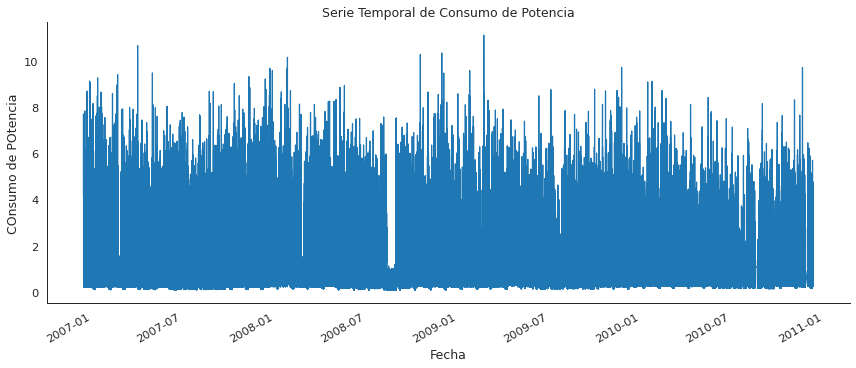

In [13]:
df1=df.loc[:,['Fecha','Potencia_Activa']]
df1.set_index('Fecha',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('COnsumo de POtencia')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Serie Temporal de Consumo de Potencia')
sns.despine(top=True)
plt.show();

**Zoom a solo 15 días**

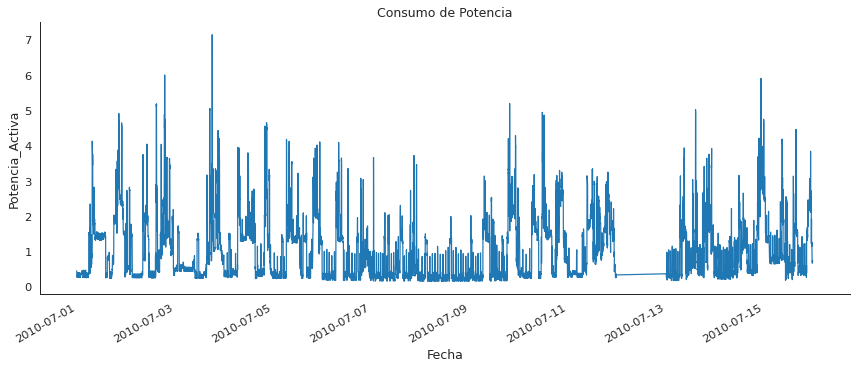

In [10]:

df2=df1[(df1.index>='2010-07-01') & (df1.index<'2010-7-16')]
df2.plot(figsize=(12,5));
plt.ylabel('Potencia_Activa')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.title("Consumo de Potencia")
plt.show();

#Estudio de la Distribución de Consumo de Potencia



**D’Agostino’s K^2 Test**

---


p <= alpha: No  posee distribución normal.

p > alpha: Posee distribución normal.

alph = 0.05

In [11]:
 stat, p = stats.normaltest(df.Potencia_Activa)
print('Estadística=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Los datos poseen distribución normal')
else:
    print('Los datos no poseen distribución normal')

Estadística=741661.563, p=0.000
Los datos no poseen distribución normal


,count,mean,std,min,25%,50%,75%,max
Potencia_Activa,2075259.0000,1.0916,1.0507,0.0760,0.3100,0.6300,1.5200,11.1220


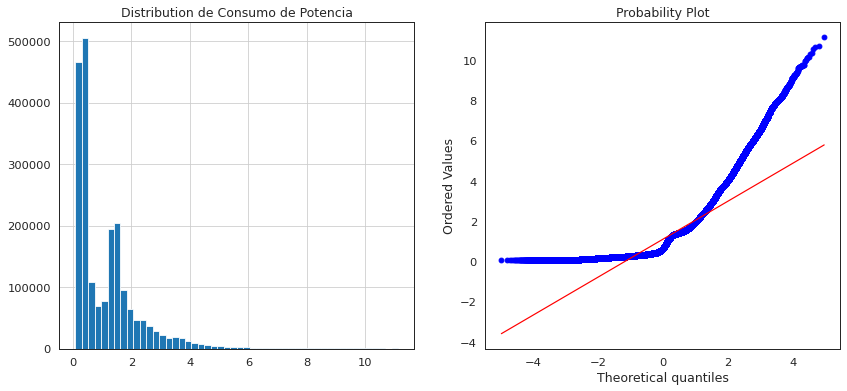

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Potencia_Activa'].hist(bins=50)
plt.title('Distribution de Consumo de Potencia')

plt.subplot(1,2,2)
stats.probplot(df['Potencia_Activa'], plot=plt);
df1.describe().T

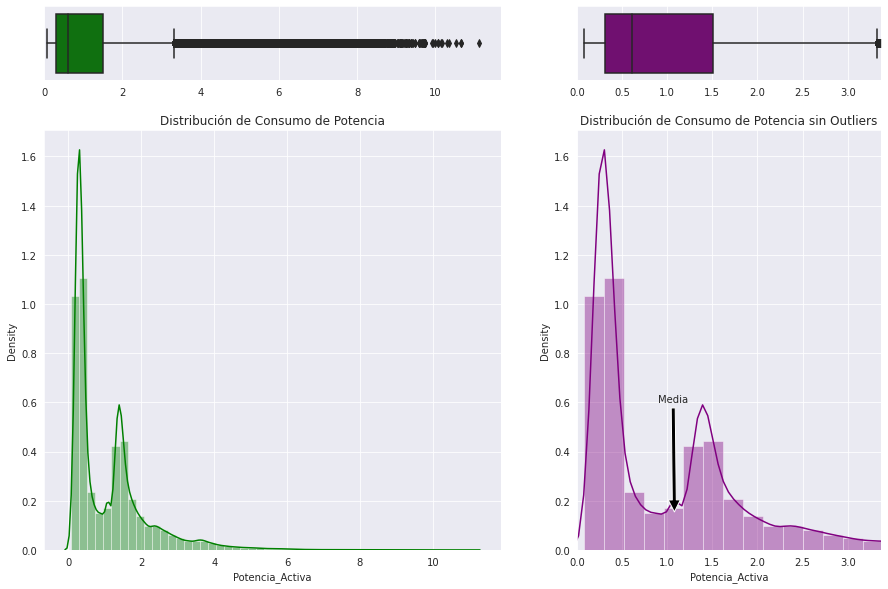

In [ ]:
# Crear subplots
f, axes = plt.subplots(2,
                       2, 
                       figsize=(15, 10), 
                       sharex=False, 
                       gridspec_kw={"height_ratios": (.15, .85),"width_ratios":(.60,.40)})
#Boxplot
sns.boxplot(df['Potencia_Activa'] , color="green", ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)

#Distribución de Consumo de Potencia
sns.distplot(df['Potencia_Activa'] , color="green", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribución de Consumo de Potencia')

# Boxplot con Zoom
sns.boxplot(df['Potencia_Activa'], color="purple", ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

# Distribución con Zoom
sns.distplot(df['Potencia_Activa'], color="purple", ax=axes[1,1])
axes[1,1].set_title('Distribución de Consumo de Potencia sin Outliers')
axes[1,1].set_xlim(0, 3.37) 

# Marcador de la Media
axes[1,1].annotate(
'Media', xy=(df['Potencia_Activa'].mean(), .15), xytext=(.9, .6),
arrowprops=dict(facecolor='black', shrink=0.01))

plt.show()

#Características de la Serie Temporal de Consumo de Potencia





**Muestreo de consumo de potencia promedio durante el día, semana, mes, trimestre y año.**

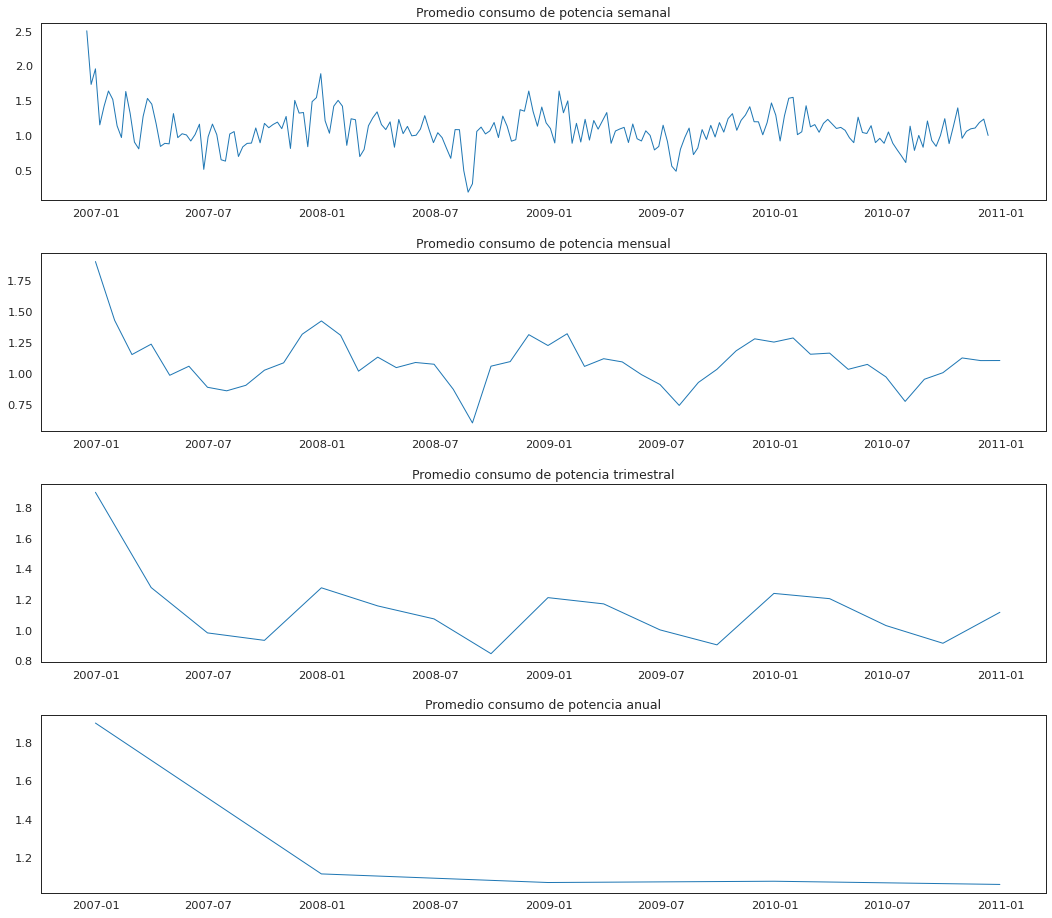

In [17]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.3)
ax1 = fig.add_subplot(4,1,1)
ax1.plot(df1['Potencia_Activa'].resample('W').mean(),linewidth=1)
ax1.set_title('Promedio consumo de potencia semanal')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(4,1,2, sharex=ax1)
ax2.plot(df1['Potencia_Activa'].resample('M').mean(),linewidth=1)
ax2.set_title('Promedio consumo de potencia mensual')
ax2.tick_params(axis='both', which='major')

ax3  = fig.add_subplot(4,1,3, sharex=ax1)
ax3.plot(df1['Potencia_Activa'].resample('Q').mean(),linewidth=1)
ax3.set_title('Promedio consumo de potencia trimestral')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(4,1,4, sharex=ax1)
ax4.plot(df1['Potencia_Activa'].resample('A').mean(),linewidth=1)
ax4.set_title('Promedio consumo de potencia anual')
ax4.tick_params(axis='both', which='major');

Se puede apreciar que, en general, nuestra serie de tiempo no tiene una tendencia general al alza o a la baja. El consumo de energía promedio más alto fue antes de 2007, disminuyó significativamente en un año hasta principios de 2008 y se ha mantenido constante desde entonces.

In [ ]:
#   Cambiar la frecuancia del dataset a horas:
df = df.resample('H').sum()

#   Guardar los cambios en un nuevo archivo:
df.to_csv('/content/drive/MyDrive/household_Hours_test.csv', index = "Fecha")

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/household_Hours_test.csv', header=0, low_memory=False, infer_datetime_format=True, parse_dates = True)


In [ ]:
df.describe()

,Potencia_Activa
count,33600.000000
mean,64.841794
std,53.080385
min,7.440000
25%,20.519500
50%,48.555000
75%,93.362500
max,393.632000


In [ ]:
data_x_plots = pd.read_csv('/content/drive/MyDrive/household_Hours.csv', header=0, low_memory=False, infer_datetime_format=True, parse_dates = True)

data_x_plots.insert(0, 'Dates', pd.to_datetime(data_x_plots['Fecha'])) 
data_x_plots.insert(2, 'Year',data_x_plots['Dates'].dt.year) 
data_x_plots.insert(3, 'Month',data_x_plots['Dates'].dt.month) 
data_x_plots.insert(4, 'Day',data_x_plots['Dates'].dt.weekday) 
data_x_plots.insert(5, 'Hour',data_x_plots['Dates'].dt.hour)



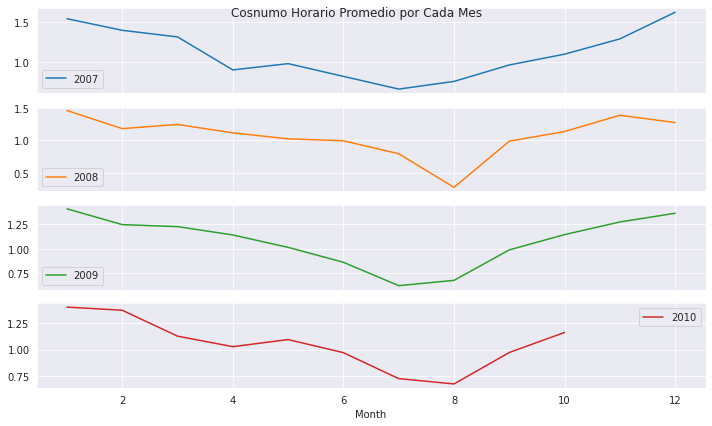

In [ ]:
pd.pivot_table(data_x_plots.loc[data_x_plots['Year'] != 2006], values = "Potencia_Activa",
        columns = "Year", index = "Month").plot(subplots = True, figsize=(10, 6), layout=(4, 1), sharex=True, grid=True, title = "Cosnumo Horario Promedio por Cada Mes")

plt.xscale('linear')

plt.tight_layout()
plt.show()

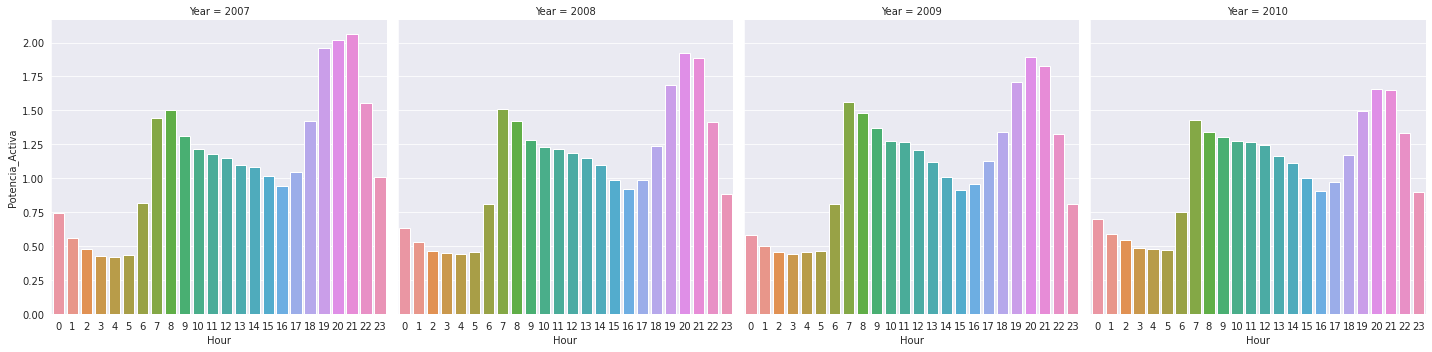

In [ ]:
summary = data_x_plots.groupby(by=['Year','Month','Day','Hour'],
                                    as_index=False)[['Potencia_Activa']].mean()

hour_plot = sns.catplot(x="Hour", y="Potencia_Activa", data=summary,
        kind="bar",
        col="Year",
        ci=None,
        )

plt.tight_layout()

In [ ]:
sumary_mena = data_x_plots.groupby(
    by=['Year','Month','Day'],
    as_index=False)[['Potencia_Activa']].mean()

In [ ]:
summary_min = data_x_plots.groupby(
    by=['Year','Month','Day'],
    as_index=False)[['Potencia_Activa']].min()

In [ ]:
summary_max = data_x_plots.groupby(
    by=['Year','Month','Day'],
    as_index=False)[['Potencia_Activa']].max()

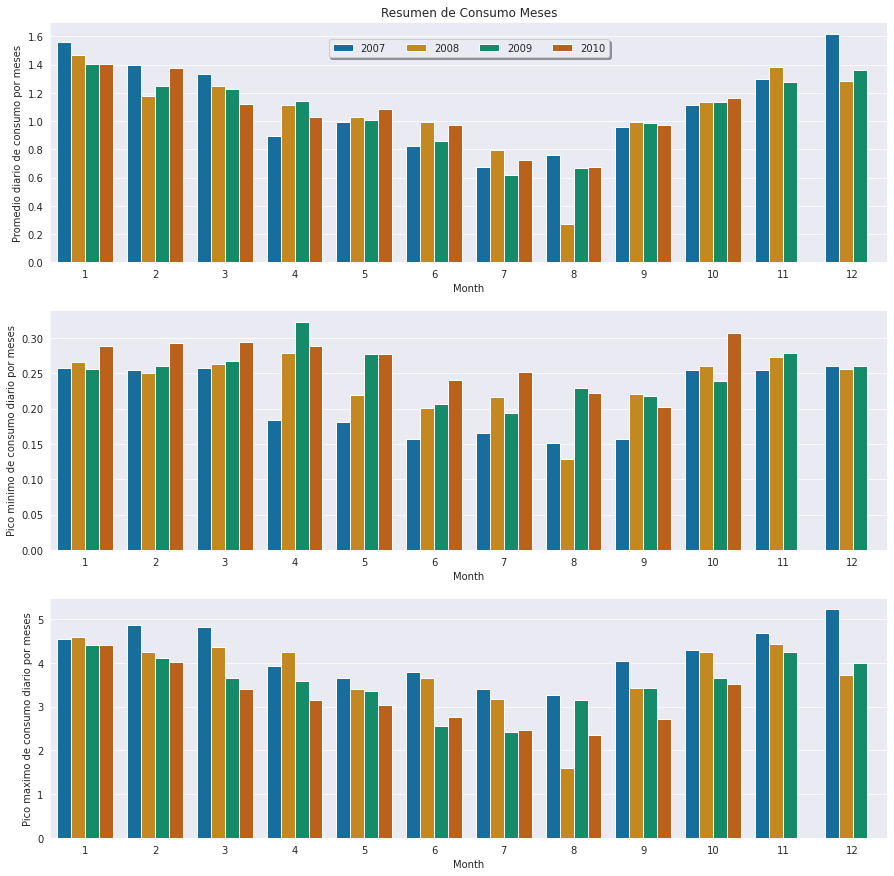

In [ ]:
sns.set_style("darkgrid")
f, axes = plt.subplots(3, figsize=(15, 15), sharex=False)

# Subplot de Media Mensual
mean = sns.barplot(x = summary.Month,
            y = summary.Potencia_Activa,
            hue = summary.Year,
            palette = "colorblind",
            ax=axes[0],
            ci=None)
mean.set_title('Resumen de Consumo Meses')
mean.set_ylabel('Promedio diario de consumo por meses')
mean.legend_.remove()

# Subplot de Consumo Minimo Mensual
min = sns.barplot(x = summary_min.Month,
            y = summary_min.Potencia_Activa,
            hue = summary_min.Year,
            palette="colorblind",
            ax=axes[1],
            ci=None)
min.legend_.remove()
min.set_ylabel('Pico minimo de consumo diario por meses')

# Subplot de Consumo Pico Mensual
max = sns.barplot(x = summary_max.Month,
            y = summary_max.Potencia_Activa,
            hue = summary_max.Year,
            palette="colorblind",
            ax=axes[2],
            ci=None) 
max.set_ylabel('Pico maximo de consumo diario por meses')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.35), shadow=True, ncol=5)
